# Purpose

Learning more about NN's with the MNIST challenge. Best submission currently at 0.98421

## To do

~~Normalization of the data~~

~~Augmentation of the data~~

Implement early stopping

~~Add more layers~~

~~Try max pooling~~

~~Try dropout layer~~

~~Confusion matrix to find out what errors are made~~

In [1]:
#Import packages
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

2023-10-14 08:09:01.505252: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
#Load data
train0 = pd.read_csv('train.csv')
test0 = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

In [3]:
#Separate target from training set. No missing data
y_train = train0['label']
train1 = train0.drop(labels=['label'], inplace=False, axis = 1)

In [4]:
#Possibly augment the data
datagen = ImageDataGenerator(
    rotation_range=10,      # Randomly rotate images by up to 10 degrees
    width_shift_range=0.1,  # Randomly shift images horizontally by up to 10% of the width
    height_shift_range=0.1, # Randomly shift images vertically by up to 10% of the height
    zoom_range=0.1,         # Randomly zoom in by up to 10%
    shear_range=0.1,        # Apply shear transformations
    fill_mode='nearest'     # Fill in missing pixels with the nearest value
)

# Create DataFrames to store augmented data
augmented_images = pd.DataFrame()
augmented_labels = pd.DataFrame()

batch_size = 32
nbr_batches = 1000

for batch_number in range(nbr_batches):
    batch = next(datagen.flow(train1.values.reshape(-1, 28, 28, 1), y_train, batch_size=batch_size))
    x_batch, y_batch = batch[0], batch[1]
    
    # Reshape x_batch to match the original shape
    x_batch = x_batch.reshape(-1, 28 * 28)
    #print(x_batch.reshape(-1, 28 * 28).shape)
    #print(y_batch.shape)
    augmented_images = pd.concat([augmented_images, pd.DataFrame(x_batch)], ignore_index=True)
    augmented_labels = pd.concat([augmented_labels, pd.DataFrame(y_batch)], ignore_index=True)
      
    if (batch_number+1)%100==0:
        print(f"Generated batch {batch_number+1}/{nbr_batches}")

augmented_labels = augmented_labels.squeeze()
augmented_images.columns = train1.columns
# Combine the original and augmented data back to DataFrames
train2 = pd.concat([train1, augmented_images], axis=0, ignore_index=True)
y_train2 = pd.concat([y_train, augmented_labels], ignore_index=True)



Generated batch 100/1000
Generated batch 200/1000
Generated batch 300/1000
Generated batch 400/1000
Generated batch 500/1000
Generated batch 600/1000
Generated batch 700/1000
Generated batch 800/1000
Generated batch 900/1000
Generated batch 1000/1000
(32000, 784)
(32000,)
(42000, 784)
(74000, 784)
(42000,)
(74000,)


In [5]:
#Possibly normalize
scaler = StandardScaler()
train3 = scaler.fit_transform(train2)
test1 = scaler.fit_transform(test0)

In [6]:
#Split the training data into test and validation set
X_train, X_val, y_train, y_val = train_test_split(train3, y_train2, test_size=0.2, random_state=42)
X_train_reshaped = np.reshape(X_train, (-1, 28, 28, 1))
X_val_reshaped = np.reshape(X_val, (-1, 28, 28, 1))
test1_reshaped = np.reshape(test1, (-1, 28, 28, 1))


In [7]:
#Multinomal logistic regression as a baseline, accuracy on validation set ~0.9
#clf = LogisticRegression(random_state=0, max_iter=1000).fit(X_train, y_train)

In [8]:
#Score the logistic regression model
#clf.score(X_val,y_val)

In [9]:
#Building a convolutional neural network
model = Sequential()

# First Conv2D layer
model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=(28, 28, 1)))
model.add(Dropout(0.5))

# Second Conv2D layer
model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
model.add(Dropout(0.5))

# Optional: Add a max pooling layer
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(units=10, activation='softmax'))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 dropout (Dropout)           (None, 26, 26, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 dropout_1 (Dropout)         (None, 24, 24, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 64)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 9216)              0         
                                                        

2023-10-14 08:13:02.429617: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
#Fit the model
history = model.fit(X_train_reshaped, y_train, epochs=10, 
                    validation_data=(X_val_reshaped, y_val))

Epoch 1/10
1850/1850 [==============================] - 58s 31ms/step - loss: 0.2598 - accuracy: 0.9203 - val_loss: 0.1375 - val_accuracy: 0.9672
Epoch 2/10
1850/1850 [==============================] - 62s 34ms/step - loss: 0.1202 - accuracy: 0.9627 - val_loss: 0.1228 - val_accuracy: 0.9714
Epoch 3/10
1850/1850 [==============================] - 53s 29ms/step - loss: 0.0931 - accuracy: 0.9707 - val_loss: 0.0945 - val_accuracy: 0.9762
Epoch 4/10
1850/1850 [==============================] - 54s 29ms/step - loss: 0.0774 - accuracy: 0.9751 - val_loss: 0.0712 - val_accuracy: 0.9805
Epoch 5/10
1850/1850 [==============================] - 54s 29ms/step - loss: 0.0671 - accuracy: 0.9785 - val_loss: 0.0754 - val_accuracy: 0.9795
Epoch 6/10
1850/1850 [==============================] - 63s 34ms/step - loss: 0.0608 - accuracy: 0.9798 - val_loss: 0.0701 - val_accuracy: 0.9801
Epoch 7/10
1850/1850 [==============================] - 66s 36ms/step - loss: 0.0563 - accuracy: 0.9815 - val_loss: 0.0687 -

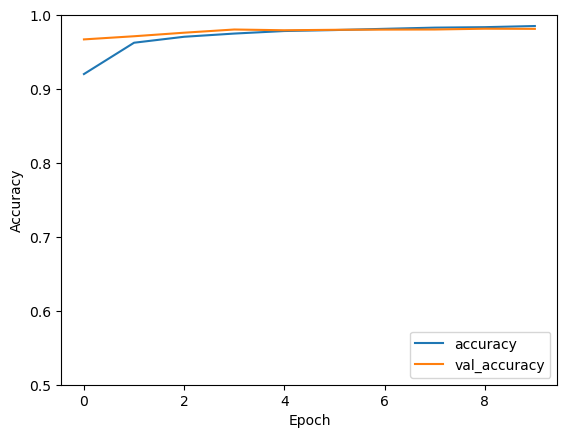

Validation Loss: 0.0626
Validation Accuracy: 98.14%


In [11]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.show()

loss, accuracy = model.evaluate(X_val_reshaped, y_val, verbose=0)

print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy*100:.2f}%")

463/463 [==============================] - 2s 5ms/step


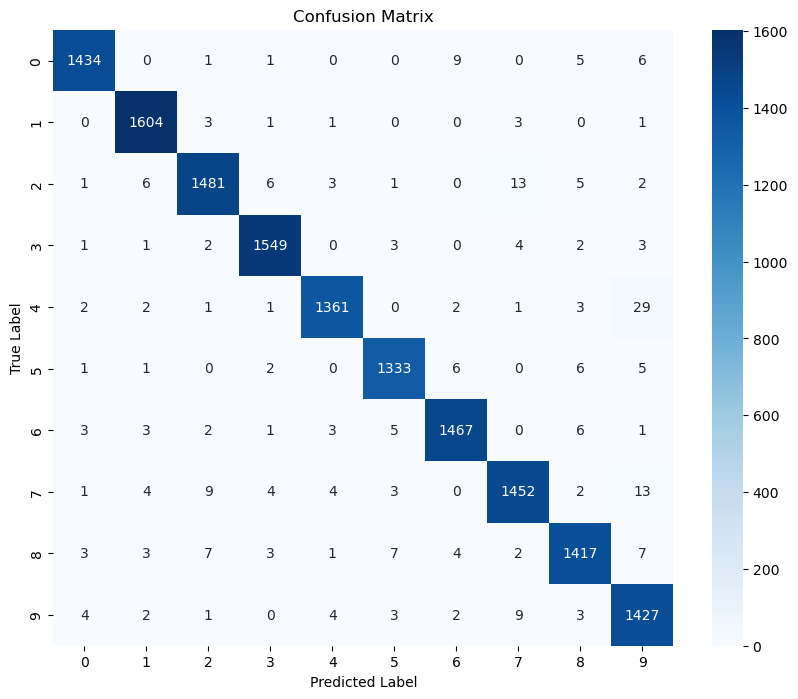

In [12]:
#Confusion matrix
probabilities_val = model.predict(X_val_reshaped)
predicted_val_labels = np.argmax(probabilities_val, axis=1)
cm = confusion_matrix(y_val, predicted_val_labels)

# Display using Seaborn's heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

#8's and 7's are most often mistaken, intersstingly enough both for 2's. If we look to expand the dataset,
#that is probably where we should focus our efforts.

In [13]:
#Predictions for test set
probabilities_test = model.predict(test1_reshaped)
predicted_labels_test = np.argmax(probabilities_test, axis=1)

875/875 [==============================] - 4s 5ms/step


In [14]:
image_ids = np.arange(1, len(predicted_labels_test) + 1)
df = pd.DataFrame({'ImageId': image_ids, 'Label': predicted_labels_test})

In [15]:
df.to_csv('./Submissions/003_submission.csv', index=False, header=True)

## Perfomance

### 000
Comment: CNN, two layers

Score: 0.97107

### 001
Comment: CNN, added dropout layer

Score: 0.97389

### 002
Comment: CNN, two conv2D layers with dropout (50%), and a max pooling layer after the second

Score: 0.98421

### 003
Comment: Added augmented data to the training set

Score: 0.98675